# Projet fil rouge Innoscape -  Comparaison d'embeddings pour la classification de texte

Objectif : Déterminir la représentation la plus appropriée pour les descriptifs de produits parmi les 3 méthodes suivantes :
        - latent semantic indexing (LSI)
        - non-negative matrix factorisation (NMF)
        - latent Dirichlet allocation (LDA)

Méthode : nous comparons les embeddings selon différents criètres :
        - intelligibilité des topics
        - résultats des modèles entaînés dans les différents embeddings

## Importation des librairies

In [15]:
# Librairies 
import pandas as pd
import numpy as np
from scipy import stats as scs
from scipy import sparse
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.stem.snowball import FrenchStemmer
import re
import random

from preprocessing import *
from gensim import models, corpora

from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split, cross_val_score

pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 60)

import xgboost as xgb
#import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

chemin = "../../Data/"

## Importation des données

#### Dataset complet

In [20]:
df_total = pd.read_csv(chemin+'t3_all_fr_prices_posweekly_prod_without_price_preprocessed.csv')

#remplissage des cellules vides et concaténation de tous les champs texte
df_total = df_total.fillna("")
df_total["concat"] = df_total['productfamily_seller_clean'] + ' ' + \
                     df_total['prodcategory4_seller_clean'] + ' ' + \
                     df_total['prodcategory3_seller_clean'] + ' ' + \
                     df_total['prodcategory2_seller_clean'] + ' ' + \
                     df_total['prodcategory1_seller_clean'] + ' ' + \
                     df_total['productseller_name_clean']

#### Dataset étiqueté

In [21]:
labels = pd.read_excel(chemin+"df_train-4.xlsx").set_index('Index')
labels_dict = dict(enumerate(labels['Product_family_innoscape'].unique()))
reverse_dict = dict(zip(labels_dict.values(),labels_dict.keys()))

## TF-IDF

In [22]:
# TF-IDF avec gensim
texts = [[word for word in document.lower().split()] for document in df_total['concat']]
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]
tfidf = models.TfidfModel(corpus)
vectors = tfidf[corpus]

## Génération des embeddings

#### 1-LSI

##### Détermination de la dimension théorique de l'embedding

Pour estimer la dimension optimale d'un embedding LSI, on peut essayer de calculer les valeus propres et vecteurs propres de la matrice d'occurrences, afin d'isoler les topics contribuant le plus à la variance dans le corpus :

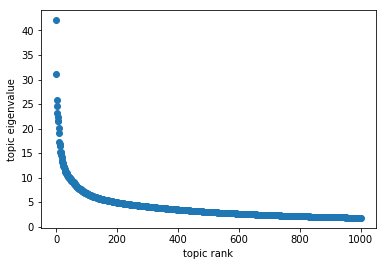

In [23]:
n_dim = 1000
lsi = models.LsiModel(vectors, id2word=dictionary, num_topics=n_dim)
corpus_lsi = lsi[vectors]

#affichage des valeurs propres pour déterminer le bon nombre de topics
eigenvalues = lsi.projection.s
plt.scatter(range(n_dim),eigenvalues)
plt.xlabel('topic rank')
plt.ylabel('topic eigenvalue')
plt.show()

Commentaire : au vu de ce qui précède, il paraît raisonnable de ne conserver que les 150 premiers topics.

##### Génération de l'embedding

In [9]:
#on refait un embedding lsi en ne gardant que les 200 topics correspondant aux valeurs propres les plus élevées
lsi2 = models.LsiModel(vectors, id2word=dictionary, num_topics=150)
corpus_lsi2 = lsi2[vectors]

#### 2 - LDA

##### Détermination de la dimension théorique de l'embedding

Pour estimer la dimension optimale d'un embedding LDA, nous avons essayé de nous appuyer sur les mesures de cohérence des topics proposées par la librairie Gensim

C:\Users\JN\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


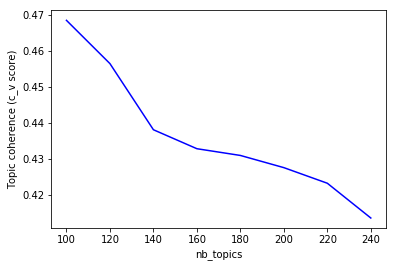

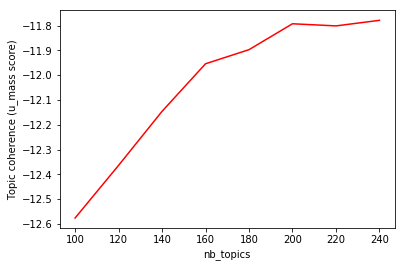

In [11]:
#calcul des scores de cohérence pour différentes dimensions
from gensim.models.coherencemodel import CoherenceModel

embedding_sizes = range(100,260,20)
u_mass_scores = []
c_v_scores = []

for num_topics in embedding_sizes:
    lda = models.LdaModel(vectors, id2word=dictionary, num_topics=num_topics, chunksize = 3000)
    coherence_model_lda = CoherenceModel(model=lda, texts=texts, dictionary=dictionary, coherence='c_v')
    c_v_scores.append(coherence_model_lda.get_coherence())
    coherence_model_lda = CoherenceModel(model=lda, texts=texts, dictionary=dictionary, coherence='u_mass')
    u_mass_scores.append(coherence_model_lda.get_coherence())

#affichage des scores
chart_cv = plt.plot(embedding_sizes, c_v_scores, color='b')
plt.xlabel('nb_topics')
plt.ylabel('Topic coherence (c_v score)')
plt.show()

chart_u_mass = plt.plot(embedding_sizes, u_mass_scores, color='r')
plt.xlabel('nb_topics')
plt.ylabel('Topic coherence (u_mass score)')
plt.show()

Au vu de l'évolution des scores, il paraît pertinent de retenir une dimension de 100 pour la LDA:

##### Génération de l'embedding

In [13]:
lda = models.LdaModel(vectors, id2word=dictionary, num_topics=100, chunksize = 3000)

#### 3 - NMF

Note : les modules de NMF proposés par Gensim ne semblent pas fonctionner ; aussi, nous avons utilisés les modules de NMF de scikit learn. Ceci nous a également contraints à utiliser les outils de tf-idf de scikit learn pour générer cet embedding.

In [14]:
# Transformation en tfidf avec la librairie Sklearn
vectorizer = TfidfVectorizer(lowercase=False)
tf_idf_skl = sparse.csr_matrix(vectorizer.fit_transform(df_total["concat"]))
tfidf_feature_names = vectorizer.get_feature_names()

##### Génération de l'embedding

In [16]:
nmf = NMF(n_components=200, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tf_idf_skl)

#sauvegarde et chargement de l'embedding
from sklearn.externals import joblib

joblib.dump(nmf, "nmf_200topics_base.save") 
#nmf = joblib.load("nmf_200topics_base.save") 

['nmf_200topics_base.save']

## Comparaison des topics

Voyons à présent les topics issus de ces embeddings:

##### Topics - LSI:

In [20]:
lsi2.show_topics()

[(0,
  '0.693*"tuile" + 0.338*"terre" + 0.321*"cuit" + 0.219*"ardoise" + 0.202*"couverture" + 0.178*"accessoire" + 0.155*"rive" + 0.100*"rouge" + 0.090*"douille" + 0.087*"droit"'),
 (1,
  '0.598*"gouttiere" + 0.259*"toiture" + 0.248*"bardage" + 0.218*"accessoire" + 0.209*"raccord" + 0.191*"charpente" + 0.191*"eau" + 0.176*"materiau|materiaux" + 0.174*"descente" + 0.157*"evacuation"'),
 (2,
  '0.421*"terre" + 0.401*"cuit" + -0.379*"ardoise" + 0.283*"gouttiere" + -0.273*"accessoire" + -0.266*"tuile" + -0.244*"charpente" + 0.203*"couverture" + -0.129*"toiture" + 0.125*"eau"'),
 (3,
  '0.467*"mastic" + 0.336*"adhesif" + 0.291*"outillage" + 0.282*"peinture" + 0.261*"electroportatif" + 0.255*"colle" + 0.233*"quincaillerie" + 0.203*"etancheite" + 0.154*"coller" + 0.148*"perceur"'),
 (4,
  '-0.346*"charpente" + 0.342*"eau" + -0.327*"toiture" + -0.307*"bardage" + 0.217*"tuile" + 0.216*"evacuation" + 0.200*"electroportatif" + 0.172*"outillage" + 0.167*"traitement" + 0.157*"chauffe"'),
 (5,
  '-0

##### Topics - LDA:

In [18]:
lda.show_topics()

[(14,
  '0.147*"pcs" + 0.142*"scie" + 0.103*"electroportatif" + 0.100*"circulaire" + 0.072*"sauteur|sauteuse" + 0.056*"outillage" + 0.045*"bois" + 0.038*"scier" + 0.029*"electrique" + 0.027*"egoine"'),
 (69,
  '0.118*"longueur" + 0.114*"ter" + 0.095*"vertical" + 0.076*"raccordement" + 0.046*"pret" + 0.044*"mural" + 0.038*"europanneton" + 0.034*"chauffe" + 0.029*"emploi" + 0.026*"rive"'),
 (29,
  '0.174*"gaz" + 0.116*"boire" + 0.064*"easy" + 0.051*"incorporer" + 0.046*"type" + 0.033*"avoir" + 0.032*"filtre" + 0.030*"interrupteur" + 0.028*"eau" + 0.024*"disjoncteur"'),
 (66,
  '0.175*"masse" + 0.076*"egout" + 0.065*"reparation" + 0.058*"mastic" + 0.058*"coller" + 0.043*"souple" + 0.042*"colle" + 0.040*"tout" + 0.040*"adhesif" + 0.027*"fixotuile"'),
 (98,
  '0.251*"bloc" + 0.064*"tuile" + 0.062*"onglet" + 0.059*"scie" + 0.056*"protect" + 0.054*"plaque" + 0.036*"couverture" + 0.021*"lumiere" + 0.017*"electrique" + 0.013*"materiau|materiaux"'),
 (75,
  '0.154*"meuleuse" + 0.153*"electroport

##### Topics - NMF:

In [21]:
# on affiche les topics à l'aide d'une fonction ad hoc:

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i] + " " + str(round(topic[i],2))
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

# on se concentre sur les 4 premiers mots de chaque topic:
n_top_words = 4
print_top_words(nmf, tfidf_feature_names, n_top_words)

Topic #0: tuile 13.27 ardoise 0.41 couverture 0.23 huguenot 0.16
Topic #1: gouttiere 7.09 sol 2.23 bardage 2.13 revetement 2.11
Topic #2: terre 8.37 cuit 8.33 tuile 5.32 couverture 3.65
Topic #3: peinture 5.23 adhesif 4.35 mastic 3.61 quincaillerie 2.05
Topic #4: electroportatif 6.6 quincaillerie 3.6 outillage 2.5 charbon 0.37
Topic #5: charpente 5.24 bardage 4.12 toiture 3.97 menuiserie 2.13
Topic #6: tondeur 4.68 tondeuse 4.68 autoporte 2.82 tailler 1.25
Topic #7: evacuation 3.6 traitement 3.44 eau 3.25 accessoire 1.51
Topic #8: gros 4.17 œuvre 4.12 voirie 2.81 bpe 2.73
Topic #9: ite 4.19 finition 1.72 enduire 1.44 isolation 1.29
Topic #10: etancheite 6.71 toiture 1.96 materiau 0.93 materiaux 0.89
Topic #11: sans 4.66 fil 4.35 batterie 1.01 perceur 0.64
Topic #12: chauffe 4.8 eau 4.14 electrique 1.58 chaud 1.46
Topic #13: gauche 5.72 rive 4.33 tuile 0.71 equerrer 0.44
Topic #14: coller 4.65 mastic 2.1 colle 1.96 droguerie 1.52
Topic #15: batterie 4.74 chargeur 3.98 lithium 1.52 outil

##### Bilan de la comparaison

De notre point de vue, la NMF semble être plus performante que les deux autres embeddings du point de vue de l'expressivité des topics. En effet, les topics paraissent plus cohérent et accordent un plus fort poids aux deux ou trois premiers mots que les autres embeddings, ce qui facilite leur interpréation.

La LSI produit également des topics relativement clairs, mais les pondérations négatives associées à certains mots rendent l'interprétation des topics plus complexe.

Néanmoins, même dans le cas de la NMF, on s'aperçoit que certains topics a priori importants peuvent difficilement être attribués préférentiellement à une famille de produits. De manière générale, il paraît difficile d'établir des correspondances univoques entre les topics et les familles. Aussi, une classification non supervisée fondée sur un embedding particulier ne nous paraît pas opportune.

## Comparaison des scores

Nous avons utilisé ces embeddings pour entraîner différents modèles :

### 1-LSI

#### Conversion des données dans l'embedding

In [34]:
data_lsi2 = lsi2[vectors]

# Création de la matrice de features X et des labels Y
from gensim import matutils
X = pd.DataFrame(matutils.corpus2csc(data_lsi2).T.todense(), index=df_total.index.values)

# Dictionnaire des topics/axes factoriels 
topic_dict = dict(lsi2.show_topics())

Y = labels['Product_family_innoscape'].apply(lambda x: reverse_dict[x])

X_labelled = X.loc[labels.index.values]
unlabelled_idx = [i for i in X.index.values if i not in labels.index.values]
X_unlabelled = X.loc[unlabelled_idx]
Y = labels['Product_family_innoscape'].apply(lambda x: reverse_dict[x])

#### Meilleur classifieur

In [35]:
clf_ex = ExtraTreesClassifier(max_depth=100,random_state=42, n_estimators=2000,n_jobs=-1)
scores = cross_val_score(clf_ex, X_labelled, Y, cv=10) 
print(scores, np.mean(scores))

C:\Users\JN\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


[0.67836257 0.72891566 0.74303406 0.7192429  0.80065359 0.83050847
 0.84805654 0.88686131 0.86692015 0.78174603] 0.788430129784166


### 2-LDA

#### Conversion des données dans l'embedding

In [36]:
data_lda = lda[vectors]

# Création de la matrice de features X et des labels Y
from gensim import matutils
X = pd.DataFrame(matutils.corpus2csc(data_lda).T.todense(), index=df_total.index.values)

# Dictionnaire des topics/axes factoriels 
topic_dict = dict(lda.show_topics())

Y = labels['Product_family_innoscape'].apply(lambda x: reverse_dict[x])

X_labelled = X.loc[labels.index.values]
unlabelled_idx = [i for i in X.index.values if i not in labels.index.values]
X_unlabelled = X.loc[unlabelled_idx]
Y = labels['Product_family_innoscape'].apply(lambda x: reverse_dict[x])

#### Meilleur classifieur

In [37]:
clf_ex = ExtraTreesClassifier(max_depth=100,random_state=42, n_estimators=2000,n_jobs=-1)
scores = cross_val_score(clf_ex, X_labelled, Y, cv=10) 
print(scores, np.mean(scores))

C:\Users\JN\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


[0.55847953 0.59036145 0.59752322 0.64984227 0.71568627 0.8
 0.82332155 0.82481752 0.79847909 0.71031746] 0.7068828364352722


### 3-NMF

#### Conversion des données dans l'embedding

In [39]:
X = pd.DataFrame(nmf.transform(tf_idf_skl)).set_index(df_total.index.values)
X_labelled = X.loc[labels.index.values]
unlabelled_idx = [i for i in X.index.values if i not in labels.index.values]
X_unlabelled = X.loc[unlabelled_idx]
Y = labels['Product_family_innoscape'].apply(lambda x: reverse_dict[x])

#### Meilleur classifieur

In [40]:
clf_ex = ExtraTreesClassifier(max_depth=100,random_state=42, n_estimators=2000,n_jobs=-1)
scores = cross_val_score(clf_ex, X_labelled, Y, cv=10) 
print(scores, np.mean(scores))

C:\Users\JN\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


[0.66081871 0.74096386 0.74922601 0.74763407 0.79411765 0.8440678
 0.86572438 0.88321168 0.86692015 0.77380952] 0.792649382449189


# Conclusion

Nous observons que, parmi les trois embeddings étudiés, la NMF à 200 dimensions est celui qui produit les meilleurs résultats en prédiction sur un dataset de référence. Sa performance n'est pas très éloignée de celle de la LSI, mais la NMF a l'avantage de produire des topics plus facilement interprétables que la LSI. Aussi, cet embedding nous paraît le plus adapté pour ce cas d'usage.